# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [12]:
torch.normal(0,1,(5,2))

tensor([[-0.8212,  0.5698],
        [ 0.6002,  2.4337],
        [ 1.4753,  0.0408],
        [ 0.8347, -0.2505],
        [-0.0309,  1.7980]])

In [13]:
torch.matmul(
    torch.normal(0,1,(5,2)),
    torch.tensor([2,-3.4]))

tensor([ -2.8068,   2.2197,   1.5920, -10.8562,   1.6969])

In [19]:
torch.normal(0, 0.01, (1,5)).reshape(-1,1)

tensor([[ 0.0035],
        [ 0.0046],
        [ 0.0162],
        [-0.0133],
        [ 0.0047]])

In [20]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [21]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.5466,  0.0488]) 
label: tensor([2.9331])


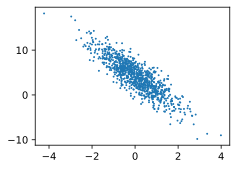

In [22]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [23]:
len(features)

1000

In [30]:
nl = list(range(1000))
random.shuffle(nl)
nl[0:15]

[654, 851, 216, 984, 968, 62, 987, 863, 222, 136, 212, 668, 980, 838, 225]

In [34]:
nl[0:10]

[654, 851, 216, 984, 968, 62, 987, 863, 222, 136]

In [35]:
nl[10:20]

[212, 668, 980, 838, 225, 437, 752, 763, 50, 903]

In [36]:
nl[20:30]

[606, 220, 26, 368, 689, 498, 319, 612, 411, 97]

In [37]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.7733, -0.3456],
        [ 0.4053,  1.0678],
        [ 2.6804,  1.0405],
        [-0.4674, -1.4095],
        [-0.0961,  0.9398],
        [ 0.6140,  0.1808],
        [-0.5187,  0.2746],
        [ 0.2934, -0.1326],
        [-0.7640, -0.5535],
        [-0.1183,  1.2739]]) 
 tensor([[ 3.8317],
        [ 1.3705],
        [ 6.0246],
        [ 8.0513],
        [ 0.8144],
        [ 4.8276],
        [ 2.2281],
        [ 5.2302],
        [ 4.5636],
        [-0.3649]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [58]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w,b

(tensor([[ 0.0065],
         [-0.0019]], requires_grad=True),
 tensor([0.], requires_grad=True))

定义模型，将模型的输入和参数同模型的输出关联起来

In [39]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [40]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [42]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [59]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.050871
epoch 2, loss 0.000214
epoch 3, loss 0.000046
epoch 4, loss 0.000045
epoch 5, loss 0.000046
epoch 6, loss 0.000046
epoch 7, loss 0.000046
epoch 8, loss 0.000045
epoch 9, loss 0.000045
epoch 10, loss 0.000045


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [61]:
w,b

(tensor([[ 2.0004],
         [-3.4001]], requires_grad=True),
 tensor([4.2001], requires_grad=True))

In [60]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004,  0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([-7.8678e-05], grad_fn=<RsubBackward1>)


In [100]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# w = torch.zeros(2, requires_grad=True)
# b = torch.zeros(1, requires_grad=True)
b = torch.normal(0,0.01, size=(1,), requires_grad=True)

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.050958
epoch 2, loss 0.000223
epoch 3, loss 0.000046
w的估计误差: tensor([ 8.7619e-05, -9.9087e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
